<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [1]:
# check for gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [2]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-04-04 04:10:59--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.006s  

2023-04-04 04:10:59 (43.8 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [3]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [5]:
len(df)

3108

In [6]:
3108/365

8.515068493150684

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [8]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


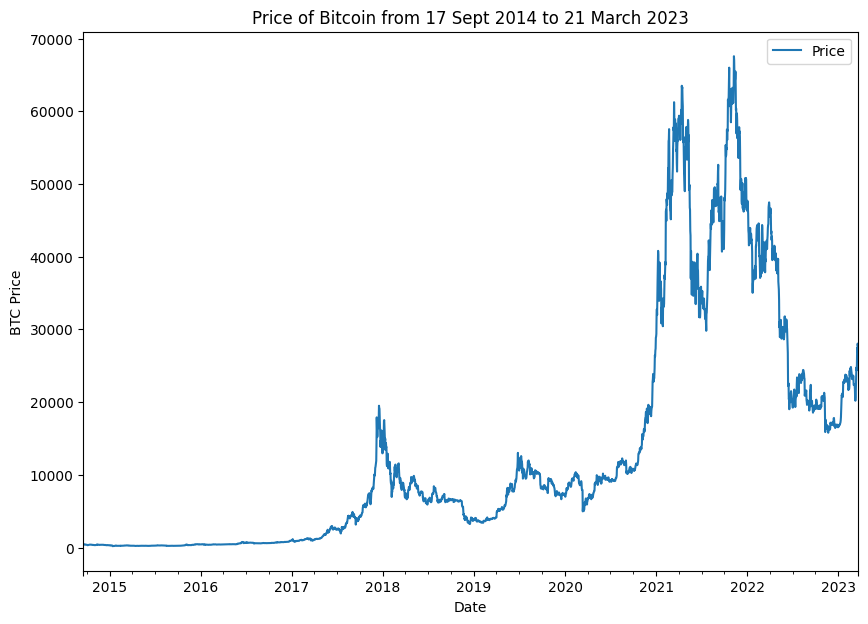

In [9]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

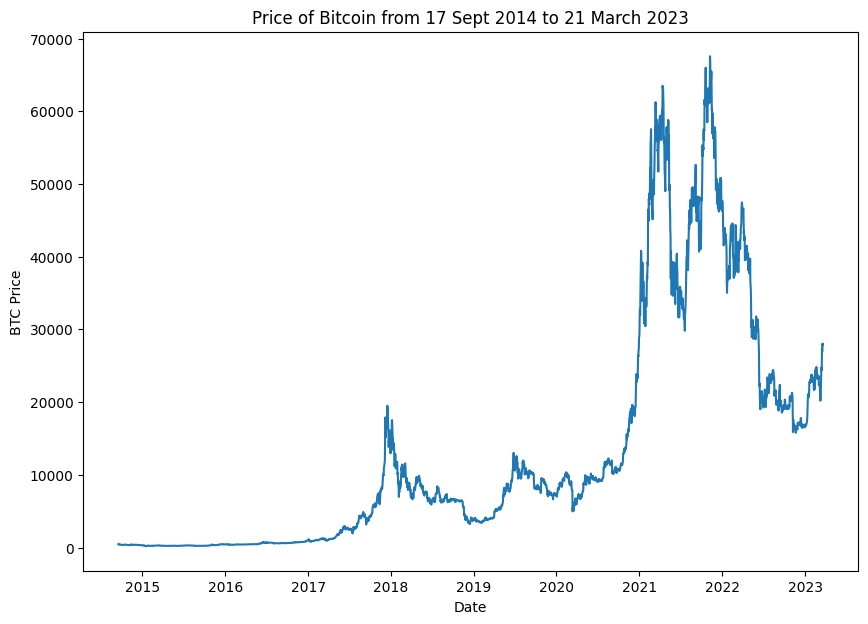

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

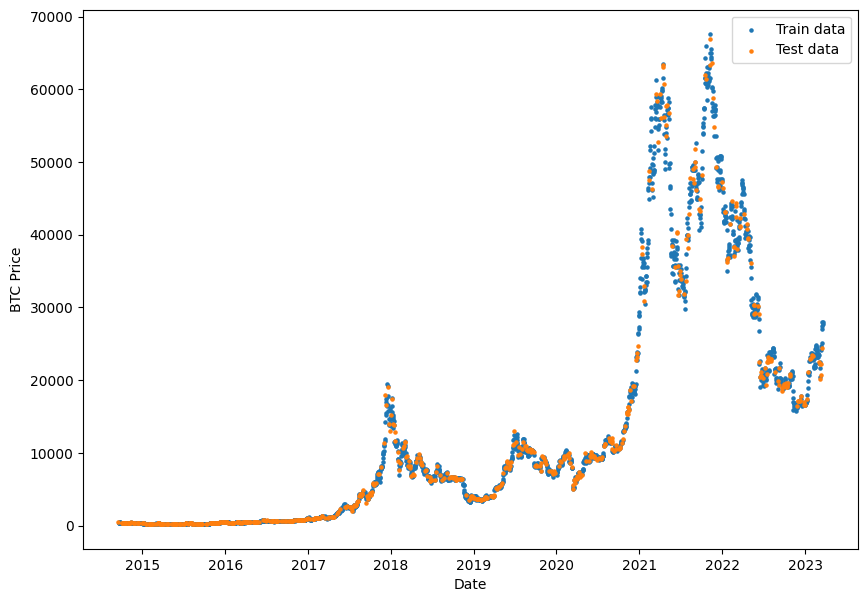

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [14]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

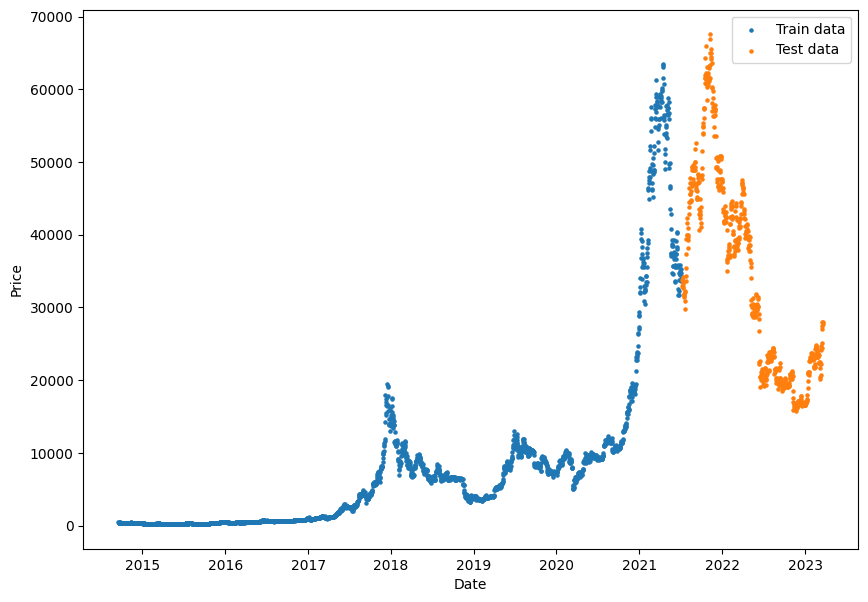

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

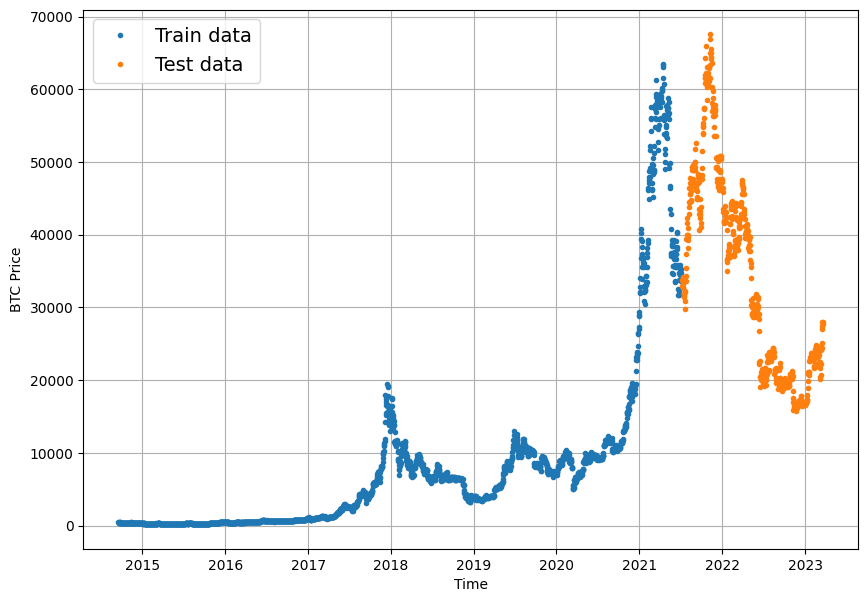

In [17]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [18]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

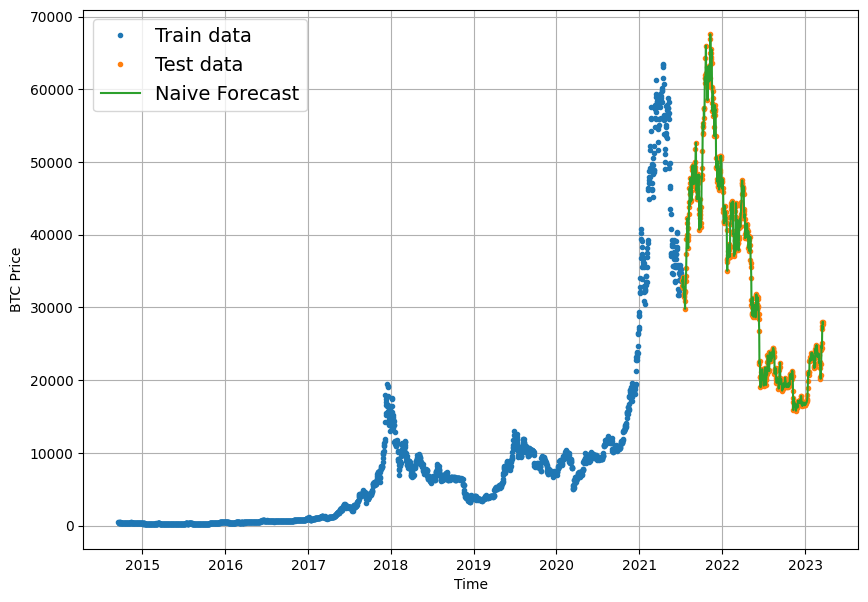

In [19]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


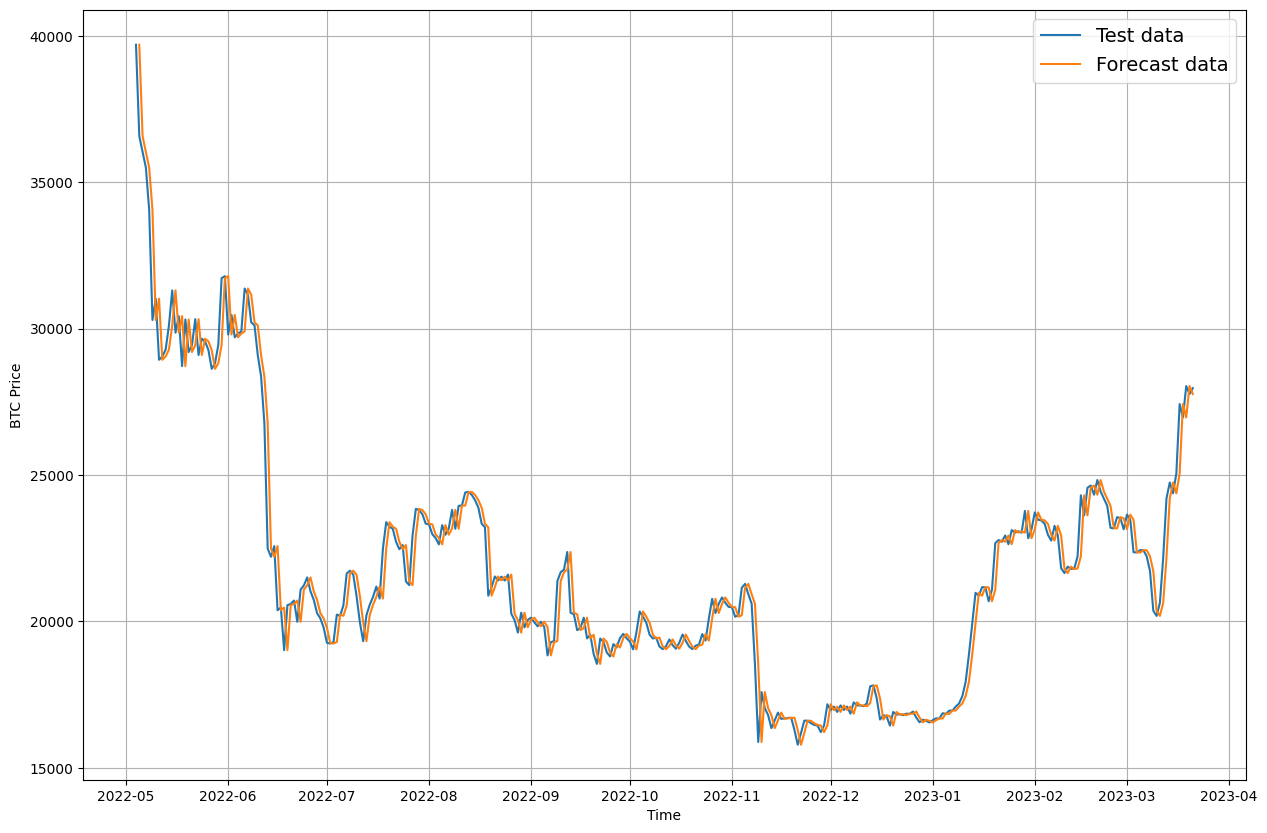

In [20]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [21]:
import tensorflow as tf

In [22]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [25]:
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [28]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [32]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [34]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [35]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/20 [>.............................] - ETA: 13s - loss: 5206.1890 - mae: 5206.1890

20/20 [==============================] - 2s 46ms/step - loss: 2265.0259 - mae: 2265.0259 - val_loss: 4377.7192 - val_mae: 4377.7192
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 1172.5669 - mae: 1172.5669

20/20 [==============================] - 1s 31ms/step - loss: 617.5903 - mae: 617.5903 - val_loss: 2091.7834 - val_mae: 2091.7834
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 584.4897 - mae: 584.4897

20/20 [==============================] - 1s 37ms/step - loss: 516.3129 - mae: 516.3129 - val_loss: 1590.7916 - val_mae: 1590.7916
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 489.5595 - mae: 489.5595 - val_loss: 1717.6678 - val_mae: 1717.6678
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 492.7271 - mae: 492.7271

20/20 [==============================] - 1s 46ms/step - loss: 475.0206 - mae: 475.0206 - val_loss: 1523.3242 - val_mae: 1523.3242
Epoch 6/100
 1/20 [>.............................] - ETA: 0s - loss: 497.9896 - mae: 497.9896

20/20 [==============================] - 1s 43ms/step - loss: 452.5411 - mae: 452.5411 - val_loss: 1505.5356 - val_mae: 1505.5356
Epoch 7/100
 1/20 [>.............................] - ETA: 0s - loss: 351.6469 - mae: 351.6469

20/20 [==============================] - 1s 42ms/step - loss: 431.7847 - mae: 431.7847 - val_loss: 1353.6881 - val_mae: 1353.6881
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 445.7552 - mae: 445.7552 - val_loss: 1641.1902 - val_mae: 1641.1902
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 453.1329 - mae: 453.1329 - val_loss: 1661.0123 - val_mae: 1661.0123
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 476.6767 - mae: 476.6767

20/20 [==============================] - 1s 66ms/step - loss: 401.8863 - mae: 401.8863 - val_loss: 1293.5233 - val_mae: 1293.5233
Epoch 11/100
18/20 [==========================>...] - ETA: 0s - loss: 371.9274 - mae: 371.9274

20/20 [==============================] - 1s 48ms/step - loss: 377.8498 - mae: 377.8498 - val_loss: 1247.5317 - val_mae: 1247.5317
Epoch 12/100
 1/20 [>.............................] - ETA: 0s - loss: 465.3831 - mae: 465.3831

20/20 [==============================] - 1s 64ms/step - loss: 360.6308 - mae: 360.6308 - val_loss: 1182.0352 - val_mae: 1182.0352
Epoch 13/100
14/20 [====================>.........] - ETA: 0s - loss: 359.7569 - mae: 359.7569

20/20 [==============================] - 1s 45ms/step - loss: 340.0124 - mae: 340.0124 - val_loss: 1060.2111 - val_mae: 1060.2111
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 321.2414 - mae: 321.2414 - val_loss: 1107.7419 - val_mae: 1107.7419
Epoch 15/100
17/20 [========================>.....] - ETA: 0s - loss: 308.1411 - mae: 308.1411

20/20 [==============================] - 1s 49ms/step - loss: 313.0713 - mae: 313.0713 - val_loss: 1033.8624 - val_mae: 1033.8624
Epoch 16/100
14/20 [====================>.........] - ETA: 0s - loss: 320.3161 - mae: 320.3161

20/20 [==============================] - 1s 57ms/step - loss: 319.9427 - mae: 319.9427 - val_loss: 1019.6432 - val_mae: 1019.6432
Epoch 17/100
20/20 [==============================] - 0s 9ms/step - loss: 303.8159 - mae: 303.8159 - val_loss: 1048.3208 - val_mae: 1048.3208
Epoch 18/100
20/20 [==============================] - 0s 3ms/step - loss: 291.2824 - mae: 291.2824 - val_loss: 1100.9431 - val_mae: 1100.9431
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 309.1410 - mae: 309.1410 - val_loss: 1178.3978 - val_mae: 1178.3978
Epoch 20/100
16/20 [=======================>......] - ETA: 0s - loss: 302.1831 - mae: 302.1831

20/20 [==============================] - 1s 68ms/step - loss: 299.6998 - mae: 299.6998 - val_loss: 926.0598 - val_mae: 926.0598
Epoch 21/100
17/20 [========================>.....] - ETA: 0s - loss: 293.7251 - mae: 293.7251

20/20 [==============================] - 1s 78ms/step - loss: 291.8557 - mae: 291.8557 - val_loss: 904.7404 - val_mae: 904.7404
Epoch 22/100
12/20 [=================>............] - ETA: 0s - loss: 274.4316 - mae: 274.4316

20/20 [==============================] - 2s 119ms/step - loss: 279.5393 - mae: 279.5393 - val_loss: 891.7546 - val_mae: 891.7546
Epoch 23/100
20/20 [==============================] - 0s 13ms/step - loss: 274.4502 - mae: 274.4502 - val_loss: 1055.7197 - val_mae: 1055.7197
Epoch 24/100
20/20 [==============================] - 0s 10ms/step - loss: 292.2069 - mae: 292.2069 - val_loss: 948.7472 - val_mae: 948.7472
Epoch 25/100
 1/20 [>.............................] - ETA: 0s - loss: 191.5739 - mae: 191.5739

20/20 [==============================] - 1s 60ms/step - loss: 270.6680 - mae: 270.6680 - val_loss: 888.7958 - val_mae: 888.7958
Epoch 26/100
20/20 [==============================] - 0s 7ms/step - loss: 271.7326 - mae: 271.7326 - val_loss: 907.1558 - val_mae: 907.1558
Epoch 27/100
20/20 [==============================] - 0s 11ms/step - loss: 269.9379 - mae: 269.9379 - val_loss: 1064.4384 - val_mae: 1064.4384
Epoch 28/100
20/20 [==============================] - 0s 6ms/step - loss: 280.1278 - mae: 280.1278 - val_loss: 1027.3512 - val_mae: 1027.3512
Epoch 29/100
14/20 [====================>.........] - ETA: 0s - loss: 278.9263 - mae: 278.9263

20/20 [==============================] - 1s 73ms/step - loss: 270.9621 - mae: 270.9621 - val_loss: 874.9026 - val_mae: 874.9026
Epoch 30/100
20/20 [==============================] - 0s 10ms/step - loss: 271.7164 - mae: 271.7164 - val_loss: 908.4012 - val_mae: 908.4012
Epoch 31/100
20/20 [==============================] - 0s 10ms/step - loss: 264.0104 - mae: 264.0104 - val_loss: 938.6419 - val_mae: 938.6419
Epoch 32/100
20/20 [==============================] - 0s 6ms/step - loss: 270.2260 - mae: 270.2260 - val_loss: 1021.0630 - val_mae: 1021.0630
Epoch 33/100
20/20 [==============================] - 0s 7ms/step - loss: 296.3191 - mae: 296.3191 - val_loss: 1046.2739 - val_mae: 1046.2739
Epoch 34/100
20/20 [==============================] - 0s 7ms/step - loss: 267.9932 - mae: 267.9932 - val_loss: 911.0272 - val_mae: 911.0272
Epoch 35/100
20/20 [==============================] - 0s 10ms/step - loss: 272.2619 - mae: 272.2619 - val_loss: 877.9694 - val_mae: 877.9694
Epoch 36/100
20/20 [=====

20/20 [==============================] - 1s 67ms/step - loss: 266.9527 - mae: 266.9527 - val_loss: 864.3418 - val_mae: 864.3418
Epoch 40/100
20/20 [==============================] - 0s 9ms/step - loss: 278.4691 - mae: 278.4691 - val_loss: 1087.2349 - val_mae: 1087.2349
Epoch 41/100
20/20 [==============================] - 0s 7ms/step - loss: 284.4123 - mae: 284.4123 - val_loss: 893.5659 - val_mae: 893.5659
Epoch 42/100
20/20 [==============================] - 0s 8ms/step - loss: 269.9289 - mae: 269.9289 - val_loss: 890.6689 - val_mae: 890.6689
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 263.8006 - mae: 263.8006 - val_loss: 867.2980 - val_mae: 867.2980
Epoch 44/100
20/20 [==============================] - 0s 8ms/step - loss: 261.7522 - mae: 261.7522 - val_loss: 931.1765 - val_mae: 931.1765
Epoch 45/100
20/20 [==============================] - 0s 10ms/step - loss: 267.1296 - mae: 267.1296 - val_loss: 876.3950 - val_mae: 876.3950
Epoch 46/100
20/20 [=========

20/20 [==============================] - 1s 54ms/step - loss: 261.5480 - mae: 261.5480 - val_loss: 851.4628 - val_mae: 851.4628
Epoch 50/100
20/20 [==============================] - 0s 8ms/step - loss: 255.6712 - mae: 255.6712 - val_loss: 879.1663 - val_mae: 879.1663
Epoch 51/100
20/20 [==============================] - 0s 7ms/step - loss: 258.7372 - mae: 258.7372 - val_loss: 919.0698 - val_mae: 919.0698
Epoch 52/100
16/20 [=======================>......] - ETA: 0s - loss: 254.0299 - mae: 254.0299

20/20 [==============================] - 2s 79ms/step - loss: 256.6118 - mae: 256.6118 - val_loss: 849.6924 - val_mae: 849.6924
Epoch 53/100
20/20 [==============================] - 0s 15ms/step - loss: 255.2979 - mae: 255.2979 - val_loss: 851.5327 - val_mae: 851.5327
Epoch 54/100
20/20 [==============================] - 0s 17ms/step - loss: 260.8632 - mae: 260.8632 - val_loss: 853.8614 - val_mae: 853.8614
Epoch 55/100
20/20 [==============================] - 0s 14ms/step - loss: 263.3765 - mae: 263.3765 - val_loss: 926.7506 - val_mae: 926.7506
Epoch 56/100
18/20 [==========================>...] - ETA: 0s - loss: 283.4948 - mae: 283.4948

20/20 [==============================] - 2s 109ms/step - loss: 276.0174 - mae: 276.0174 - val_loss: 847.7163 - val_mae: 847.7163
Epoch 57/100
20/20 [==============================] - 0s 9ms/step - loss: 264.1332 - mae: 264.1332 - val_loss: 849.8502 - val_mae: 849.8502
Epoch 58/100
20/20 [==============================] - 0s 6ms/step - loss: 263.4055 - mae: 263.4055 - val_loss: 990.0414 - val_mae: 990.0414
Epoch 59/100
20/20 [==============================] - 0s 7ms/step - loss: 257.8278 - mae: 257.8278 - val_loss: 847.9574 - val_mae: 847.9574
Epoch 60/100
 1/20 [>.............................] - ETA: 0s - loss: 216.8020 - mae: 216.8020

20/20 [==============================] - 2s 85ms/step - loss: 256.8158 - mae: 256.8158 - val_loss: 843.2520 - val_mae: 843.2520
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 255.5248 - mae: 255.5248 - val_loss: 860.0335 - val_mae: 860.0335
Epoch 62/100
20/20 [==============================] - 0s 15ms/step - loss: 252.6254 - mae: 252.6254 - val_loss: 920.2063 - val_mae: 920.2063
Epoch 63/100
20/20 [==============================] - 0s 4ms/step - loss: 259.6075 - mae: 259.6075 - val_loss: 869.5971 - val_mae: 869.5971
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 251.1641 - mae: 251.1641 - val_loss: 868.4988 - val_mae: 868.4988
Epoch 65/100
20/20 [==============================] - 0s 9ms/step - loss: 263.9415 - mae: 263.9415 - val_loss: 910.1387 - val_mae: 910.1387
Epoch 66/100
20/20 [==============================] - 0s 7ms/step - loss: 257.8338 - mae: 257.8338 - val_loss: 855.0951 - val_mae: 855.0951
Epoch 67/100
20/20 [===========

20/20 [==============================] - 1s 53ms/step - loss: 256.1367 - mae: 256.1367 - val_loss: 840.8248 - val_mae: 840.8248
Epoch 69/100
20/20 [==============================] - 0s 3ms/step - loss: 254.4995 - mae: 254.4995 - val_loss: 1041.3851 - val_mae: 1041.3851
Epoch 70/100
20/20 [==============================] - 0s 4ms/step - loss: 277.1972 - mae: 277.1972 - val_loss: 987.2010 - val_mae: 987.2010
Epoch 71/100
 1/20 [>.............................] - ETA: 0s - loss: 210.1179 - mae: 210.1179

20/20 [==============================] - 1s 51ms/step - loss: 270.8433 - mae: 270.8433 - val_loss: 839.4020 - val_mae: 839.4020
Epoch 72/100
20/20 [==============================] - 0s 9ms/step - loss: 260.3102 - mae: 260.3102 - val_loss: 1108.6223 - val_mae: 1108.6223
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 285.1941 - mae: 285.1941 - val_loss: 876.4232 - val_mae: 876.4232
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 252.5656 - mae: 252.5656 - val_loss: 964.9330 - val_mae: 964.9330
Epoch 75/100
20/20 [==============================] - 0s 7ms/step - loss: 271.7457 - mae: 271.7457 - val_loss: 864.7404 - val_mae: 864.7404
Epoch 76/100
20/20 [==============================] - 0s 10ms/step - loss: 253.9750 - mae: 253.9750 - val_loss: 845.4890 - val_mae: 845.4890
Epoch 77/100
20/20 [==============================] - 0s 6ms/step - loss: 265.2343 - mae: 265.2343 - val_loss: 962.4043 - val_mae: 962.4043
Epoch 78/100
20/20 [=========

20/20 [==============================] - 1s 43ms/step - loss: 256.8496 - mae: 256.8496 - val_loss: 836.2390 - val_mae: 836.2390
Epoch 82/100
20/20 [==============================] - 0s 5ms/step - loss: 265.0834 - mae: 265.0834 - val_loss: 1158.6504 - val_mae: 1158.6504
Epoch 83/100
20/20 [==============================] - 0s 7ms/step - loss: 297.5246 - mae: 297.5246 - val_loss: 930.8474 - val_mae: 930.8474
Epoch 84/100
20/20 [==============================] - 0s 6ms/step - loss: 306.5951 - mae: 306.5951 - val_loss: 1032.9398 - val_mae: 1032.9398
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 292.2023 - mae: 292.2023 - val_loss: 867.2229 - val_mae: 867.2229
Epoch 86/100
20/20 [==============================] - 0s 6ms/step - loss: 259.4436 - mae: 259.4436 - val_loss: 909.5652 - val_mae: 909.5652
Epoch 87/100
20/20 [==============================] - 0s 6ms/step - loss: 260.5527 - mae: 260.5527 - val_loss: 836.8927 - val_mae: 836.8927
Epoch 88/100
20/20 [========

20/20 [==============================] - 1s 48ms/step - loss: 249.6527 - mae: 249.6527 - val_loss: 833.3869 - val_mae: 833.3869
Epoch 93/100
20/20 [==============================] - 0s 9ms/step - loss: 252.3130 - mae: 252.3130 - val_loss: 833.5134 - val_mae: 833.5134
Epoch 94/100
20/20 [==============================] - 0s 14ms/step - loss: 255.9094 - mae: 255.9094 - val_loss: 1108.5568 - val_mae: 1108.5568
Epoch 95/100
20/20 [==============================] - 0s 7ms/step - loss: 289.3836 - mae: 289.3836 - val_loss: 868.1280 - val_mae: 868.1280
Epoch 96/100
20/20 [==============================] - 0s 9ms/step - loss: 253.3379 - mae: 253.3379 - val_loss: 968.5015 - val_mae: 968.5015
Epoch 97/100
20/20 [==============================] - 0s 15ms/step - loss: 279.1093 - mae: 279.1093 - val_loss: 938.9930 - val_mae: 938.9930
Epoch 98/100
20/20 [==============================] - 0s 5ms/step - loss: 253.9190 - mae: 253.9190 - val_loss: 848.1583 - val_mae: 848.1583
Epoch 99/100
20/20 [========

In [37]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 875.7576 - mae: 875.7576


[875.757568359375, 875.757568359375]

This is the last epoch's evaluation results, but let's check the best model weights

In [38]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 833.3869 - mae: 833.3869


[833.3869018554688, 833.3869018554688]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [39]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [40]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([32920.926, 33464.375, 33582.723, 34045.137, 33345.332, 32704.008,
       32714.94 , 31871.182, 31258.959, 31384.83 ], dtype=float32)>

In [41]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [42]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 833.38696,
 'mse': 1549550.9,
 'rmse': 1244.8096,
 'mape': 2.4074647,
 'mase': 1.0000142}

In [43]:
# view the naive results
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

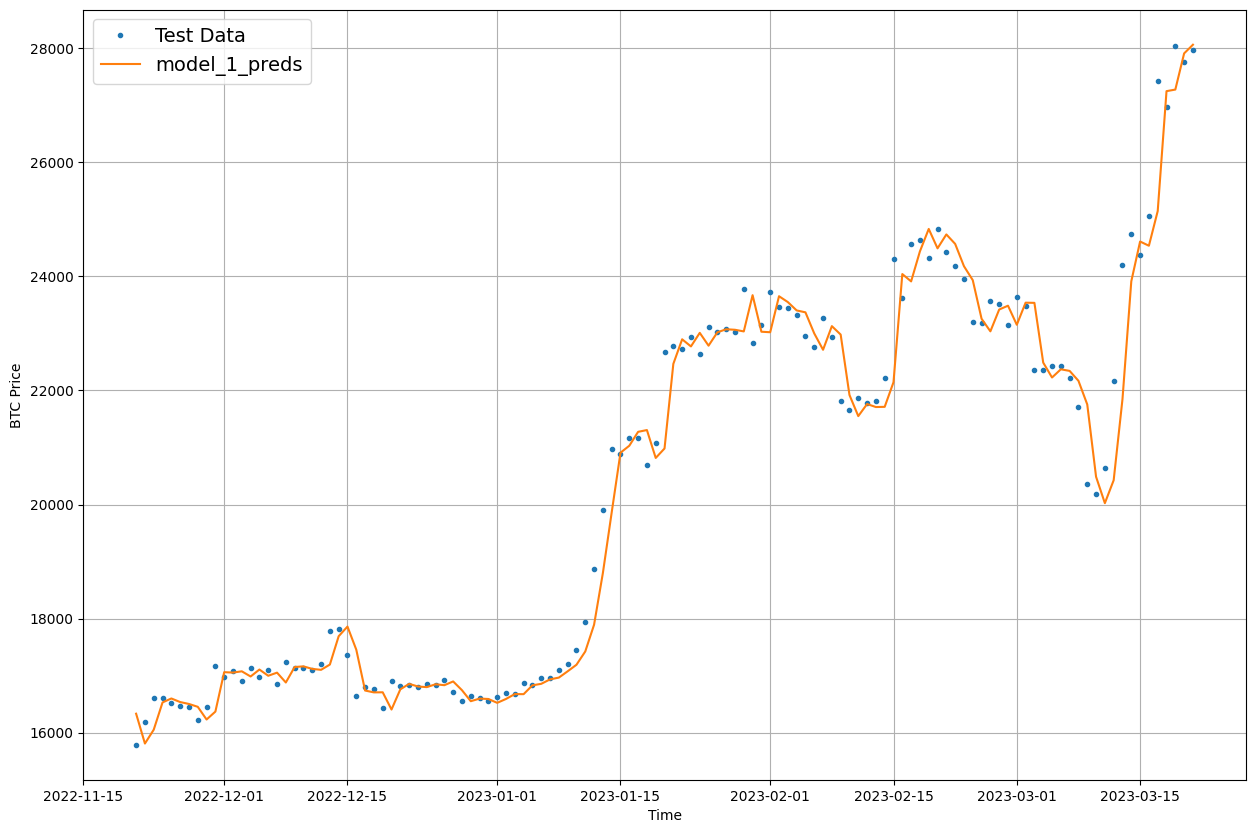

In [44]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ? 

And also predictions are little behind the actual values. For more about this, [Read Autocorrelation](https://otexts.com/fpp3/acf.html)

Since they're on the test dataset. So they're not actual forecasts that we are trying for predicting a price.

With our current model setup, we've to make forecasts for the future.

## Model 2: Dense (window=30, horizon=1)

In this model we are going to predict on window_size 30, that is past 30 days of bitcoin prices to predict next day of bitcoin price.

In [45]:
HORIZON=1
WINDOW_SIZE=30

In [46]:
# Reset the windows and labels with 30 day prices of bitcoin
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:2], full_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [47]:
# Create train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2462, 616, 2462, 616)

In [48]:
# Now ready to create our dense model

tf.random.set_seed(17)

# Create the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], 'model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# evaluate the model with the last epochs 
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1193.3915


1193.3914794921875

In [50]:
# Evaluation on the best model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 892.4716


892.4716186523438

In [51]:
# prediction on model_2
model_2_preds = make_predictions(model_2, test_windows)

# evaluate the results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

20/20 [==============================] - 0s 2ms/step


{'mae': 892.4716,
 'mse': 1721759.8,
 'rmse': 1312.1584,
 'mape': 2.5857651,
 'mase': 0.99996686}

In [52]:
model_1_results

{'mae': 833.38696,
 'mse': 1549550.9,
 'rmse': 1244.8096,
 'mape': 2.4074647,
 'mase': 1.0000142}

It looks like `model_1` performs better than `model_2`.

Also, smaller windows size is performing better so in that case we can create window size of something like 5 days.



How do the predictions look ?

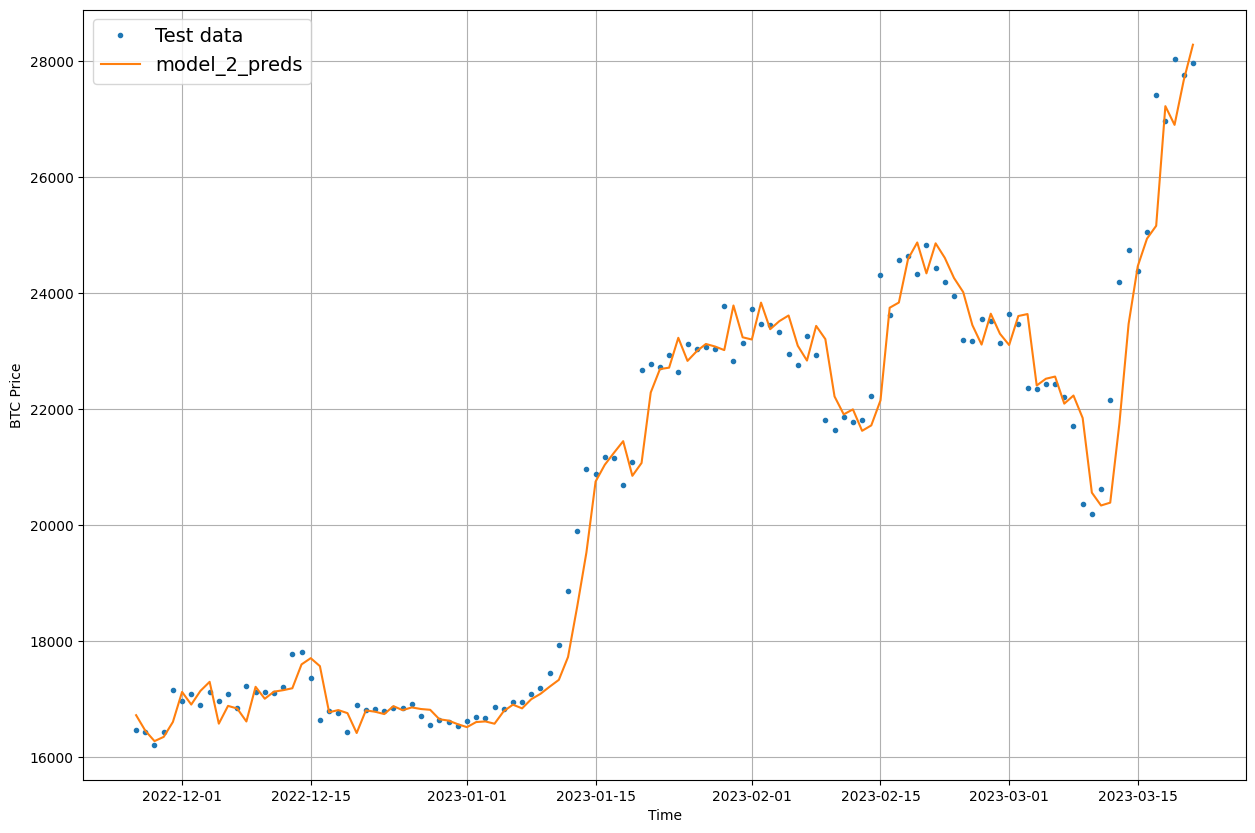

In [53]:
offset = 500
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense(window=30, horizon=7)

In [54]:
HORIZON=7
WINDOW_SIZE=30

# create windows and labels
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
         383.15799 , 358.416992],
        [391.441986, 389.54599 , 382.845001, 386.475006, 383.1579

In [55]:
len(train_windows), len(test_windows)

(2457, 615)

In [56]:
tf.random.set_seed(17)

# Create Model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# evaluation on last epoch
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 1771.5630


1771.56298828125

In [58]:
# load the best model and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1730.6956


1730.695556640625

This is going to be large because we are trying to predict 7 days in advance, for example we want to predict the weather in advance of 7 days. So there will be higher chances of wrong predictibility.

In [59]:
# Make prediction and see the results
model_3_preds = make_predictions(model_3, test_windows)

20/20 [==============================] - 0s 2ms/step


In [60]:
model_3_preds.shape, test_labels.shape

(TensorShape([615, 7]), (615, 7))

In [61]:
# view the results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': array([ 562.55133,  826.34406, 1190.0369 , 1635.7982 , 1682.3145 ,
        1422.2971 , 1298.2971 ,  975.7425 ,  995.82086, 1560.9822 ,
        2130.164  , 2805.889  , 4108.5376 , 4599.0684 , 5822.3384 ,
        5368.238  , 5140.874  , 5217.445  , 3557.0547 , 1687.1094 ,
        1134.2148 , 1032.0463 , 1820.2561 , 2355.369  , 2195.4224 ,
        2886.7605 , 4726.4673 , 4985.357  , 4330.1284 , 3459.889  ,
        1904.7963 , 2156.928  ,  969.8304 ,  976.0999 , 1369.3934 ,
        1368.9911 , 1091.3264 , 1827.7009 , 1826.5312 , 1981.1222 ,
        2525.3862 , 3127.2349 , 2389.4336 ,  910.3594 ,  825.09766,
        1416.3622 , 2347.0808 ,  983.3544 , 1014.5781 , 1025.092  ,
        1167.8197 , 1437.6278 , 1500.837  , 1855.2762 , 2362.8064 ,
        2283.1746 , 2653.8281 , 2899.135  , 3865.5776 , 5075.3257 ,
        6955.87   , 3391.0972 , 1453.918  , 1098.0803 , 1745.8538 ,
        1684.1044 , 1605.409  , 2224.8945 , 2272.3645 , 2662.5286 ,
        3266.6277 , 3785.183  , 4778.073 

This is multi-dimensional output because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this we need to adjust our `evaluate_preds()` function.

In [62]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1730.6956>

In [63]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If horizon is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Let's evaulate our `model_3` now

In [64]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1730.6956,
 'mse': 6417623.0,
 'rmse': 1977.3123,
 'mape': 5.1020293,
 'mase': 0.99998134}

In [65]:
model_2_results

{'mae': 892.4716,
 'mse': 1721759.8,
 'rmse': 1312.1584,
 'mape': 2.5857651,
 'mase': 0.99996686}

`model_3` seems even worse compared to previous modelling experiments. Let's plot the predictions.

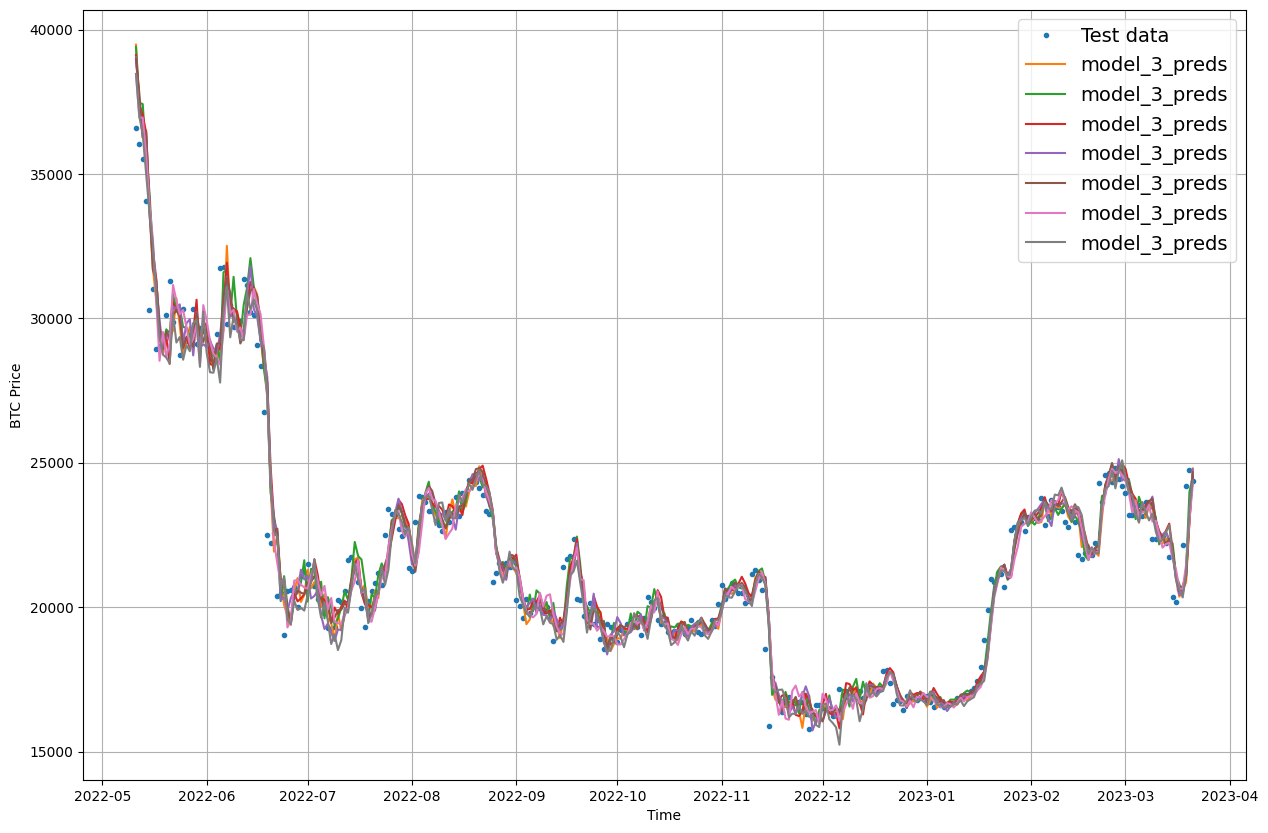

In [66]:
offset=300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,start=offset,format="-", label="model_3_preds")

Since our predictions were multi-dimensional, the plot predictions also look like stacked every timesteps together.

Let's fix this by aggregating our model's predictions.

**Note**: Aggregating the results of the predictions lead to lose in information from it's original predictions because it was originally predicted for 7 days but if we aggregate it in 1 day then it'll lose the detailed predictions.

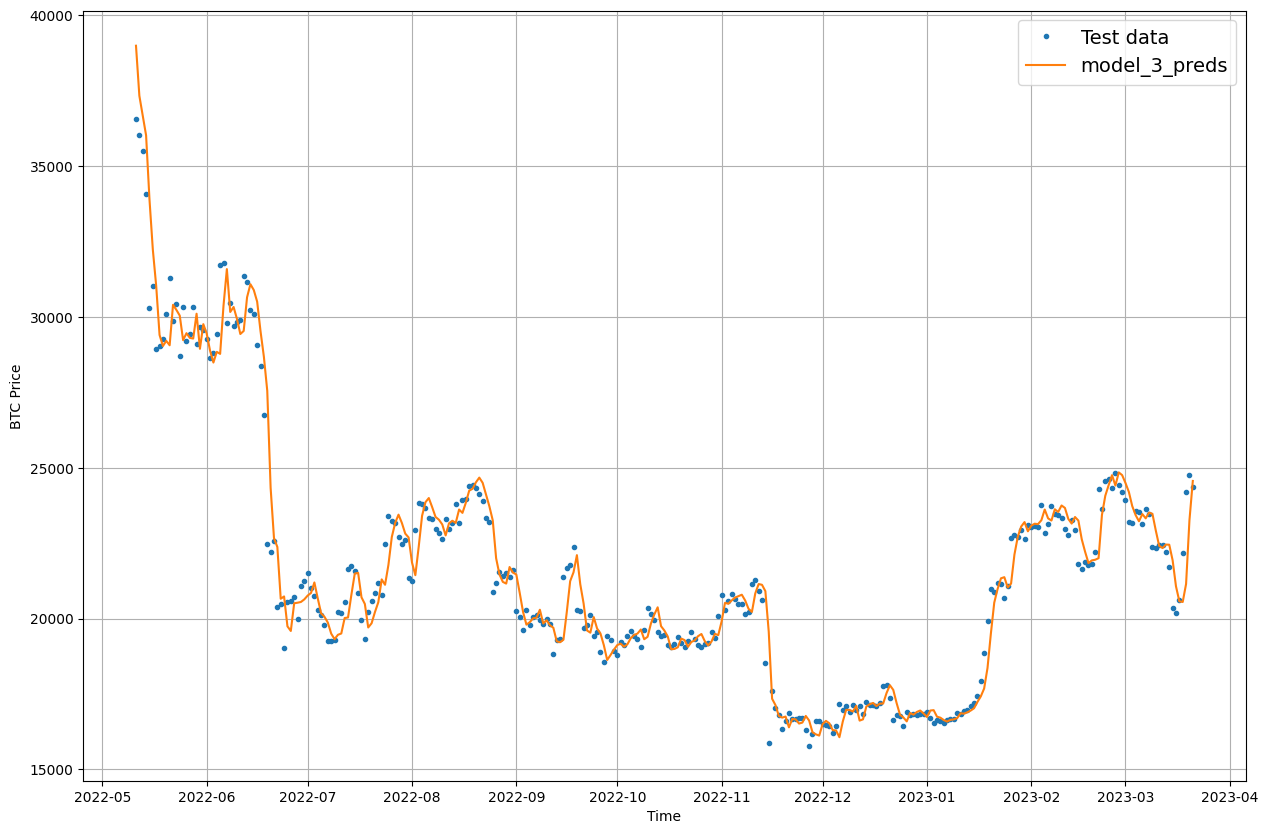

In [67]:
offset = 300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-" ,label="model_3_preds")

## Which of our model is performing best so far ?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naive model to see which model is performing the best so far.

<Axes: >

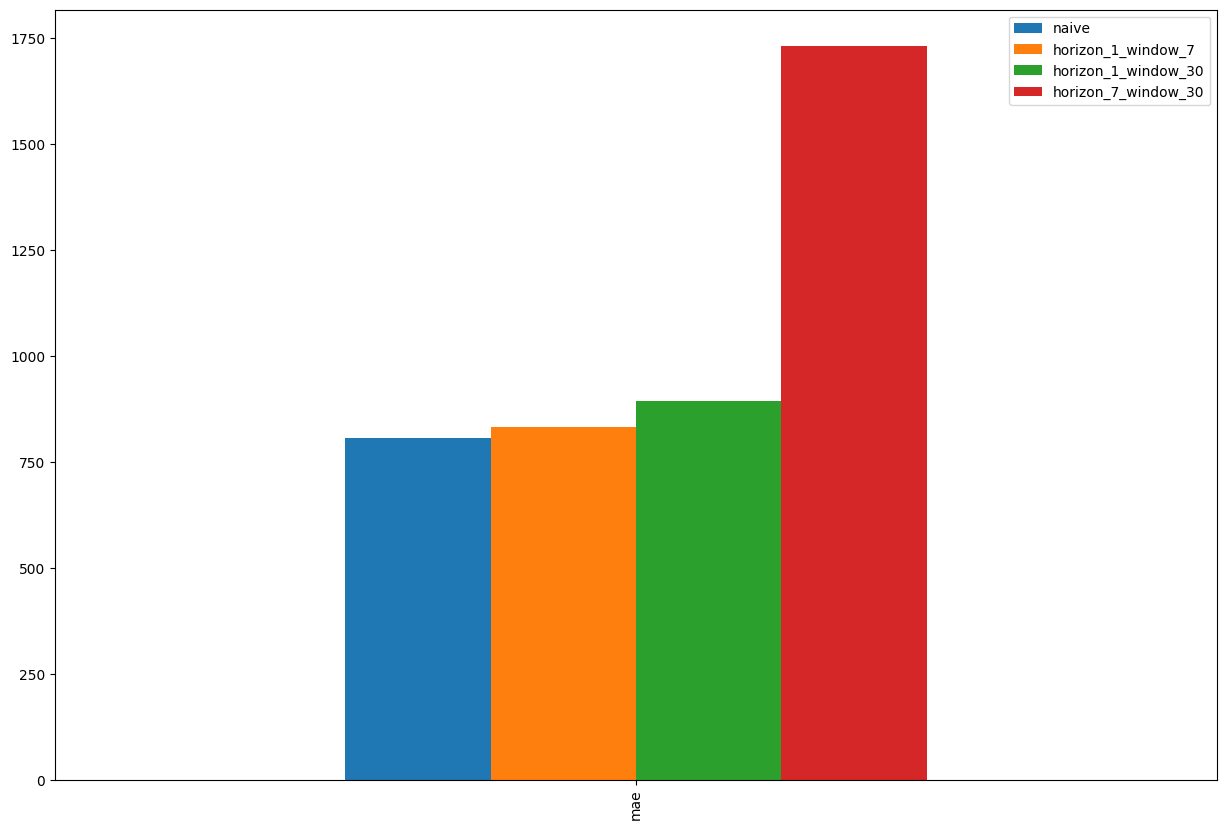

In [68]:
pd.DataFrame({"naive":naive_results['mae'],
              "horizon_1_window_7":model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=["mae"]).plot(kind='bar', figsize=(15,10))

Naive model is hard to beat in an open system, but `model_1` with HORIZON 1 and WINDOW SIZE 7 looks to be performing closest. So let's continue our experiments with only these set of horizon and window size.

💡 **Resource**: Due to autocorrelation in the time series data, naive model often performs best because the value of `t` will be closer to `t-1`. Today's value is probably pretty close to yesterday's value. This isn't always the case but when it is, a naive model will often get fairly good results.

Some more about how autocorrelation influences a model's predictions, [How (not) to use Machine learning for Time series forecasting : Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Model 4 : Conv1D

We'll be using Conv1D model as it can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is many to one problem).

In [69]:
HORIZON=1
WINDOW_SIZE=7

In [70]:
# make windows for Conv1D model
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2480, 2480, 621, 621)

In [71]:
# let's see how our training data looks like
train_windows[0]

array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])

In [72]:
# convert into tensors
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

Alright, it says the shape is 7 which is the window size. But if we see the doc of [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to convert the shape of inputs into `batch size + (timesteps, input_dim)`

In [73]:
# check the shape
x.shape

TensorShape([7])

We need to convert this into (7,1). Let's create a expand dim layer to convert the inputs shape inside the layer.

In [74]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [75]:
# Test it with the x 
expand_dim_layer(x)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[457.334],
       [424.44 ],
       [394.796],
       [408.904],
       [398.821],
       [402.152],
       [435.791]], dtype=float32)>

In [76]:
# Create the model

tf.random.set_seed(17)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
12/20 [=================>............] - ETA: 0s - loss: 5176.2949 

20/20 [==============================] - 5s 163ms/step - loss: 3806.9561 - val_loss: 1673.6240
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 732.7037 - val_loss: 2157.7693
Epoch 3/100
11/20 [===============>..............] - ETA: 0s - loss: 537.8342

20/20 [==============================] - 2s 91ms/step - loss: 503.7494 - val_loss: 1401.3500
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 441.2397 - val_loss: 1438.9966
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 428.4088

20/20 [==============================] - 4s 195ms/step - loss: 428.4088 - val_loss: 1375.6515
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 423.1507 - val_loss: 1395.1005
Epoch 7/100
11/20 [===============>..............] - ETA: 0s - loss: 413.9693

20/20 [==============================] - 3s 171ms/step - loss: 412.9085 - val_loss: 1311.4493
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 420.5881 - val_loss: 1322.4825
Epoch 9/100
 1/20 [>.............................] - ETA: 0s - loss: 404.9793

20/20 [==============================] - 2s 124ms/step - loss: 396.8236 - val_loss: 1267.0228
Epoch 10/100
20/20 [==============================] - 0s 10ms/step - loss: 389.6159 - val_loss: 1286.1998
Epoch 11/100
 8/20 [===========>..................] - ETA: 0s - loss: 364.3243

20/20 [==============================] - 2s 131ms/step - loss: 384.7037 - val_loss: 1256.2531
Epoch 12/100
20/20 [==============================] - 0s 10ms/step - loss: 385.2510 - val_loss: 1263.7612
Epoch 13/100
14/20 [====================>.........] - ETA: 0s - loss: 390.8059

20/20 [==============================] - 2s 129ms/step - loss: 376.8461 - val_loss: 1180.3608
Epoch 14/100
20/20 [==============================] - 0s 11ms/step - loss: 362.2253 - val_loss: 1314.2371
Epoch 15/100
20/20 [==============================] - 0s 16ms/step - loss: 361.2144 - val_loss: 1403.9658
Epoch 16/100
20/20 [==============================] - ETA: 0s - loss: 356.2784

20/20 [==============================] - 1s 60ms/step - loss: 356.2784 - val_loss: 1114.8774
Epoch 17/100
20/20 [==============================] - 0s 6ms/step - loss: 341.9081 - val_loss: 1184.1396
Epoch 18/100
18/20 [==========================>...] - ETA: 0s - loss: 342.2836

20/20 [==============================] - 1s 57ms/step - loss: 339.7556 - val_loss: 1068.8242
Epoch 19/100
20/20 [==============================] - 0s 5ms/step - loss: 331.7599 - val_loss: 1259.3121
Epoch 20/100
20/20 [==============================] - 0s 3ms/step - loss: 344.8568 - val_loss: 1136.6974
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 319.4468

20/20 [==============================] - 1s 56ms/step - loss: 319.4468 - val_loss: 1044.5570
Epoch 22/100
20/20 [==============================] - 0s 11ms/step - loss: 314.9147 - val_loss: 1084.1895
Epoch 23/100
20/20 [==============================] - 0s 7ms/step - loss: 327.9028 - val_loss: 1162.2699
Epoch 24/100
20/20 [==============================] - 0s 8ms/step - loss: 334.9059 - val_loss: 1082.4961
Epoch 25/100
 1/20 [>.............................] - ETA: 0s - loss: 228.4935

20/20 [==============================] - 1s 56ms/step - loss: 312.6093 - val_loss: 994.5543
Epoch 26/100
20/20 [==============================] - 0s 4ms/step - loss: 304.7793 - val_loss: 1094.6161
Epoch 27/100
20/20 [==============================] - 0s 4ms/step - loss: 303.5807 - val_loss: 1006.8424
Epoch 28/100
19/20 [===========================>..] - ETA: 0s - loss: 290.4481

20/20 [==============================] - 2s 105ms/step - loss: 293.1986 - val_loss: 978.1136
Epoch 29/100
17/20 [========================>.....] - ETA: 0s - loss: 293.6964

20/20 [==============================] - 1s 59ms/step - loss: 291.0585 - val_loss: 971.5138
Epoch 30/100
17/20 [========================>.....] - ETA: 0s - loss: 290.7241

20/20 [==============================] - 1s 65ms/step - loss: 291.8214 - val_loss: 967.2330
Epoch 31/100
20/20 [==============================] - 0s 11ms/step - loss: 290.0897 - val_loss: 972.1464
Epoch 32/100
20/20 [==============================] - 0s 19ms/step - loss: 289.1030 - val_loss: 1018.5585
Epoch 33/100
20/20 [==============================] - 0s 20ms/step - loss: 307.1554 - val_loss: 1126.2789
Epoch 34/100
13/20 [==================>...........] - ETA: 0s - loss: 294.0858

20/20 [==============================] - 3s 175ms/step - loss: 290.4792 - val_loss: 942.0787
Epoch 35/100
20/20 [==============================] - 0s 15ms/step - loss: 283.8519 - val_loss: 947.1734
Epoch 36/100
20/20 [==============================] - 0s 10ms/step - loss: 284.7628 - val_loss: 981.7398
Epoch 37/100
20/20 [==============================] - 0s 7ms/step - loss: 290.5912 - val_loss: 1005.1461
Epoch 38/100
15/20 [=====================>........] - ETA: 0s - loss: 286.1071

20/20 [==============================] - 1s 77ms/step - loss: 291.9315 - val_loss: 932.3981
Epoch 39/100
20/20 [==============================] - 0s 7ms/step - loss: 292.1863 - val_loss: 1043.0691
Epoch 40/100
20/20 [==============================] - 0s 6ms/step - loss: 298.3966 - val_loss: 1302.3329
Epoch 41/100
20/20 [==============================] - 0s 6ms/step - loss: 328.8115 - val_loss: 1154.0179
Epoch 42/100
20/20 [==============================] - 0s 7ms/step - loss: 282.5044 - val_loss: 1048.0227
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 291.7490 - val_loss: 1044.3199
Epoch 44/100
20/20 [==============================] - 0s 6ms/step - loss: 292.5264 - val_loss: 1174.3649
Epoch 45/100
18/20 [==========================>...] - ETA: 0s - loss: 291.3623

20/20 [==============================] - 1s 76ms/step - loss: 284.5145 - val_loss: 923.2960
Epoch 46/100
20/20 [==============================] - ETA: 0s - loss: 285.6199

20/20 [==============================] - 1s 70ms/step - loss: 285.6199 - val_loss: 912.1397
Epoch 47/100
 1/20 [>.............................] - ETA: 0s - loss: 192.8993

20/20 [==============================] - 1s 68ms/step - loss: 277.5815 - val_loss: 910.4813
Epoch 48/100
20/20 [==============================] - 0s 7ms/step - loss: 274.2314 - val_loss: 982.3040
Epoch 49/100
20/20 [==============================] - 0s 7ms/step - loss: 274.7942 - val_loss: 920.5790
Epoch 50/100
 1/20 [>.............................] - ETA: 0s - loss: 385.4683

20/20 [==============================] - 1s 74ms/step - loss: 272.0393 - val_loss: 904.3168
Epoch 51/100
20/20 [==============================] - 0s 6ms/step - loss: 270.0506 - val_loss: 908.7353
Epoch 52/100
20/20 [==============================] - 0s 6ms/step - loss: 269.5450 - val_loss: 917.5024
Epoch 53/100
20/20 [==============================] - 0s 7ms/step - loss: 276.6076 - val_loss: 1015.4222
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 284.4110 - val_loss: 984.8367
Epoch 55/100
20/20 [==============================] - 0s 5ms/step - loss: 271.4084 - val_loss: 1060.4067
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 286.3298 - val_loss: 968.8898
Epoch 57/100
 1/20 [>.............................] - ETA: 0s - loss: 273.4638

20/20 [==============================] - 2s 87ms/step - loss: 270.5336 - val_loss: 900.0096
Epoch 58/100
20/20 [==============================] - 0s 10ms/step - loss: 274.0675 - val_loss: 1037.7125
Epoch 59/100
20/20 [==============================] - 0s 14ms/step - loss: 301.9301 - val_loss: 1065.4039
Epoch 60/100
20/20 [==============================] - 0s 6ms/step - loss: 294.7316 - val_loss: 1003.0461
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 273.2039 - val_loss: 1009.5082
Epoch 62/100
20/20 [==============================] - 0s 6ms/step - loss: 274.2406 - val_loss: 926.9310
Epoch 63/100
20/20 [==============================] - ETA: 0s - loss: 268.1606

20/20 [==============================] - 1s 58ms/step - loss: 268.1606 - val_loss: 883.0114
Epoch 64/100
20/20 [==============================] - 0s 8ms/step - loss: 270.8085 - val_loss: 920.3737
Epoch 65/100
20/20 [==============================] - 0s 7ms/step - loss: 264.8432 - val_loss: 955.4119
Epoch 66/100
20/20 [==============================] - 0s 3ms/step - loss: 302.9433 - val_loss: 1593.2212
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 282.5388 - val_loss: 883.5408
Epoch 68/100
20/20 [==============================] - 0s 6ms/step - loss: 273.3559 - val_loss: 916.2993
Epoch 69/100
17/20 [========================>.....] - ETA: 0s - loss: 267.9447

20/20 [==============================] - 1s 53ms/step - loss: 268.8994 - val_loss: 879.7663
Epoch 70/100
20/20 [==============================] - 0s 6ms/step - loss: 275.5737 - val_loss: 964.1793
Epoch 71/100
20/20 [==============================] - 0s 6ms/step - loss: 280.9173 - val_loss: 1019.0385
Epoch 72/100
20/20 [==============================] - 0s 10ms/step - loss: 265.6740 - val_loss: 924.1073
Epoch 73/100
18/20 [==========================>...] - ETA: 0s - loss: 263.1073

20/20 [==============================] - 1s 62ms/step - loss: 268.1740 - val_loss: 872.5743
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 262.4480 - val_loss: 953.3771
Epoch 75/100
20/20 [==============================] - 0s 6ms/step - loss: 274.1757 - val_loss: 1058.5842
Epoch 76/100
20/20 [==============================] - 0s 3ms/step - loss: 278.7379 - val_loss: 884.2739
Epoch 77/100
20/20 [==============================] - 0s 3ms/step - loss: 260.9070 - val_loss: 878.2546
Epoch 78/100
 1/20 [>.............................] - ETA: 0s - loss: 339.6295

20/20 [==============================] - 1s 62ms/step - loss: 267.5255 - val_loss: 866.9443
Epoch 79/100
10/20 [==============>...............] - ETA: 0s - loss: 267.0322

20/20 [==============================] - 3s 138ms/step - loss: 258.6985 - val_loss: 864.7460
Epoch 80/100
10/20 [==============>...............] - ETA: 0s - loss: 261.2990

20/20 [==============================] - 2s 87ms/step - loss: 265.5836 - val_loss: 864.5591
Epoch 81/100
20/20 [==============================] - 0s 9ms/step - loss: 263.3124 - val_loss: 872.0477
Epoch 82/100
20/20 [==============================] - 0s 10ms/step - loss: 269.0650 - val_loss: 1110.1396
Epoch 83/100
20/20 [==============================] - 0s 12ms/step - loss: 275.3783 - val_loss: 937.4409
Epoch 84/100
20/20 [==============================] - 0s 14ms/step - loss: 288.8012 - val_loss: 958.0988
Epoch 85/100
13/20 [==================>...........] - ETA: 0s - loss: 288.9083

20/20 [==============================] - 2s 109ms/step - loss: 275.0866 - val_loss: 862.9519
Epoch 86/100
20/20 [==============================] - 0s 7ms/step - loss: 258.0445 - val_loss: 867.7260
Epoch 87/100
20/20 [==============================] - 0s 7ms/step - loss: 256.7967 - val_loss: 872.0707
Epoch 88/100
20/20 [==============================] - 0s 7ms/step - loss: 257.8703 - val_loss: 883.2137
Epoch 89/100
14/20 [====================>.........] - ETA: 0s - loss: 260.2244

20/20 [==============================] - 2s 79ms/step - loss: 263.5179 - val_loss: 857.6774
Epoch 90/100
20/20 [==============================] - 0s 6ms/step - loss: 256.7485 - val_loss: 984.7829
Epoch 91/100
20/20 [==============================] - 0s 7ms/step - loss: 258.8325 - val_loss: 859.4304
Epoch 92/100
20/20 [==============================] - 0s 5ms/step - loss: 258.9273 - val_loss: 989.0176
Epoch 93/100
20/20 [==============================] - 0s 5ms/step - loss: 263.6265 - val_loss: 866.0192
Epoch 94/100
20/20 [==============================] - 0s 7ms/step - loss: 267.6500 - val_loss: 1168.0903
Epoch 95/100
20/20 [==============================] - 0s 6ms/step - loss: 277.7361 - val_loss: 907.8323
Epoch 96/100
20/20 [==============================] - 0s 7ms/step - loss: 256.0277 - val_loss: 912.2655
Epoch 97/100
20/20 [==============================] - 0s 6ms/step - loss: 267.3107 - val_loss: 918.5062
Epoch 98/100
20/20 [==============================] - 0s 6ms/step - loss: 2

In [77]:
# check the summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [78]:
# evaluate on the last epochs model
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 929.2570


929.2569580078125

In [79]:
# load the best model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 857.6774


857.6774291992188

In [80]:
# make some predictions
model_4_preds = make_predictions(model_4, test_windows)

# evaluate the results
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                   y_pred=model_4_preds)

model_4_results

20/20 [==============================] - 0s 1ms/step


{'mae': 857.67755,
 'mse': 1631316.8,
 'rmse': 1277.2301,
 'mape': 2.4879627,
 'mase': 1.0000142}

In [81]:
model_1_results

{'mae': 833.38696,
 'mse': 1549550.9,
 'rmse': 1244.8096,
 'mape': 2.4074647,
 'mase': 1.0000142}

Close enough with `model_1` but not better than it. Let's continue our experiments.

## Model 5 : RNN (LSTM)

We can also use a recurrent neural network to model our sequential time series data.

We're not going to change the data, the data will be same just the model architecture would be different.

In [82]:
tf.random.set_seed(17)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

# compile the model
model_5.compile(loss='mae',
                optimizer='Adam')

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

In [83]:
# check the summary
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 205,377
Trainable params: 205,377
Non-tr

In [84]:
# evaluate on last epoch
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 844.7140


844.7139892578125

In [85]:
# load the best model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 844.7140


844.7139892578125

In [86]:
# make predictions and check pred results
model_5_preds = make_predictions(model_5, test_windows)

model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

model_5_results

20/20 [==============================] - 0s 3ms/step


{'mae': 844.71375,
 'mse': 1578210.1,
 'rmse': 1256.2683,
 'mape': 2.4407084,
 'mase': 1.0000142}

## Make a Multivariate time series

So far all our models predicted on univariate time series data which is only Bitcoin prices, but what are other features that may impact the price of bitcoin, that's the thing to explore.


What about the Volume ? Or Block Reward ? Could be a tweet from a famous personality like Elon Musk can fluctuate the prices. 

According to the data we have, we can use Volume and Block Reward. Then let's add these two features into our time series dataset.

In [87]:
# view the dataset
bitcoin_prices.tail()

,Price
Date,
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781
2023-03-20,27767.236328
2023-03-21,27964.888672


According to the [CMC Markets](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving) block reward events, we can assign the block reward to specific date range in our dataset.

| Block Reward	| Start Date |
| --- | --- |
| 50	| 3 January 2009 (2009-01-03) |
| 25	| 28 November 2012 |
| 12.5 |	9 July 2016 |
| 6.25 |	11 May 2020 |
| 3.125	|TBA (expected 2024) |
| 1.5625 |	TBA (expected 2028) |


And we have a data between **`2014 Sept 17th`** - **`2023 March 17th`**. Great.


In [88]:
# Block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125 # not required for our dataset

# Block reward dates
block_reward_1_date = np.datetime64("2009-01-03")
block_reward_2_date = np.datetime64("2012-11-28")
block_reward_3_date = np.datetime64("2016-07-09")
block_reward_4_date = np.datetime64("2020-05-11")
block_reward_5_date = np.datetime64("2024-04-01") # expected to be april

Let's get the number of days fall between the block reward dates in our time series dataset.

In [89]:
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_date - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_date - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days, block_reward_4_days

(661, 2063, 3484)

Now add the new feature `block_reward` in our dataset.

In [90]:
# Add block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column
                          # row, column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

Let's view head and tail of data.

In [91]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [92]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-03-17,27423.929688,6.25
2023-03-18,26965.878906,6.25
2023-03-19,28038.675781,6.25
2023-03-20,27767.236328,6.25
2023-03-21,27964.888672,6.25


Let's plot it to see how it looks like together.

<Axes: xlabel='Date'>

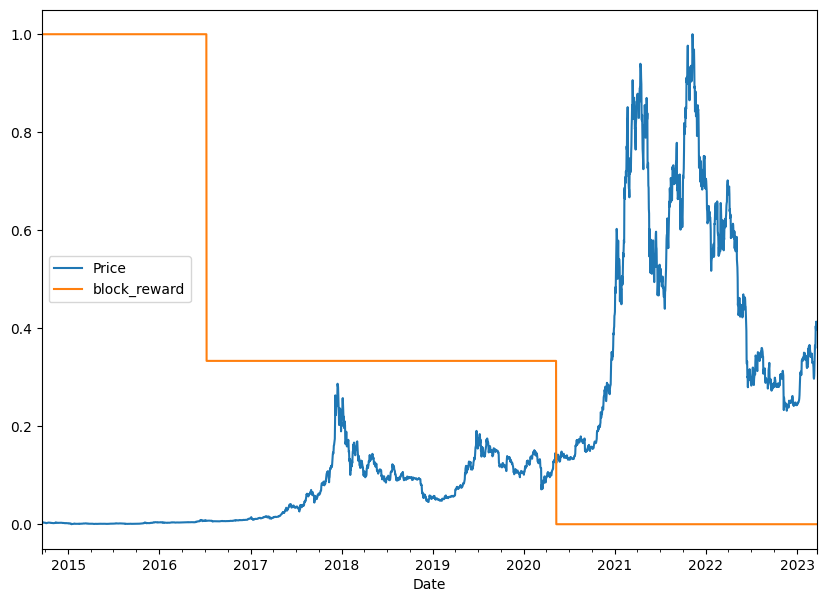

In [93]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

In the above plot when we set the same scale for prices and block reward, we can see the Prices go up when block reward get reduced.

## Making a windowed dataset with pandas

Previously we created some custom function to window our univariate time series.

Since we have added one more variable to our dataset, these functions won't work.

In pandas, there is a function called [`.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html), which can be used to create windows on multivariate time series dataset.


In [94]:
# Setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [95]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)               

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


Alright, we need to drop NaNs and make feature set and label set.

In [96]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

# Make train test split
split_size = int(len(X) * 0.8) # 80%
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [97]:
X_train.shape, X_test.shape

((2480, 8), (621, 8))

## Model 6 : Multivariate Time Series (Dense model)

We're going to build the same model like `model_1` architecture and use it to train and make predictions on our multivariate time series data.

In [98]:
tf.random.set_seed(17)

# Create the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], "model_6_multivariate_dense")

# Compile the model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name="model_6_multivariate_dense")])

Epoch 1/100
 1/20 [>.............................] - ETA: 10s - loss: 4633.4956

20/20 [==============================] - 1s 38ms/step - loss: 1774.9526 - val_loss: 1651.7401
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 606.3576

20/20 [==============================] - 1s 56ms/step - loss: 561.3251 - val_loss: 1464.9788
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 482.0898

20/20 [==============================] - 1s 33ms/step - loss: 454.9314 - val_loss: 1374.7657
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 409.7343 - val_loss: 1427.4606
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 415.9820

20/20 [==============================] - 1s 32ms/step - loss: 393.9053 - val_loss: 1238.4141
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 382.2371 - val_loss: 1295.8202
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 372.5206 - val_loss: 1250.6787
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 380.1593 - val_loss: 1511.2314
Epoch 9/100
 1/20 [>.............................] - ETA: 0s - loss: 427.1737

20/20 [==============================] - 1s 43ms/step - loss: 400.9989 - val_loss: 1191.1016
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 359.6626

20/20 [==============================] - 1s 45ms/step - loss: 353.7151 - val_loss: 1124.6350
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 326.9345

20/20 [==============================] - 1s 44ms/step - loss: 326.9345 - val_loss: 1051.7463
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 321.4124

20/20 [==============================] - 1s 34ms/step - loss: 321.4124 - val_loss: 1033.4598
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 376.1771

20/20 [==============================] - 1s 29ms/step - loss: 317.0043 - val_loss: 1009.1079
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 309.7246 - val_loss: 1124.8408
Epoch 15/100
20/20 [==============================] - 0s 3ms/step - loss: 306.2384 - val_loss: 1065.1409
Epoch 16/100
20/20 [==============================] - 0s 3ms/step - loss: 310.3441 - val_loss: 1048.8381
Epoch 17/100
20/20 [==============================] - 0s 4ms/step - loss: 306.3745 - val_loss: 1111.9955
Epoch 18/100
20/20 [==============================] - 0s 3ms/step - loss: 294.9083 - val_loss: 1308.6106
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 320.3222 - val_loss: 1207.2675
Epoch 20/100
 1/20 [>.............................] - ETA: 0s - loss: 372.4014

20/20 [==============================] - 1s 31ms/step - loss: 319.2335 - val_loss: 942.7959
Epoch 21/100
20/20 [==============================] - 0s 3ms/step - loss: 306.7636 - val_loss: 979.7831
Epoch 22/100
 1/20 [>.............................] - ETA: 0s - loss: 255.8325

20/20 [==============================] - 1s 29ms/step - loss: 284.2027 - val_loss: 932.6119
Epoch 23/100
20/20 [==============================] - 0s 3ms/step - loss: 282.4719 - val_loss: 1238.5961
Epoch 24/100
20/20 [==============================] - 0s 4ms/step - loss: 304.6005 - val_loss: 978.4171
Epoch 25/100
 1/20 [>.............................] - ETA: 0s - loss: 202.3752

20/20 [==============================] - 1s 32ms/step - loss: 279.1981 - val_loss: 917.8019
Epoch 26/100
20/20 [==============================] - 0s 3ms/step - loss: 283.7155 - val_loss: 989.8466
Epoch 27/100
20/20 [==============================] - 0s 3ms/step - loss: 294.4818 - val_loss: 1027.8053
Epoch 28/100
 1/20 [>.............................] - ETA: 0s - loss: 262.0343

20/20 [==============================] - 1s 31ms/step - loss: 277.0520 - val_loss: 913.9124
Epoch 29/100
 1/20 [>.............................] - ETA: 0s - loss: 282.6931

20/20 [==============================] - 1s 30ms/step - loss: 269.6458 - val_loss: 908.8247
Epoch 30/100
20/20 [==============================] - 0s 3ms/step - loss: 275.0937 - val_loss: 929.2408
Epoch 31/100
20/20 [==============================] - 0s 4ms/step - loss: 272.7163 - val_loss: 937.6799
Epoch 32/100
20/20 [==============================] - 0s 4ms/step - loss: 274.5539 - val_loss: 1033.1027
Epoch 33/100
 1/20 [>.............................] - ETA: 0s - loss: 220.3116

20/20 [==============================] - 1s 29ms/step - loss: 276.8606 - val_loss: 883.1396
Epoch 34/100
 1/20 [>.............................] - ETA: 0s - loss: 231.8924

20/20 [==============================] - 1s 30ms/step - loss: 266.6323 - val_loss: 881.6576
Epoch 35/100
20/20 [==============================] - 0s 3ms/step - loss: 271.2645 - val_loss: 897.9924
Epoch 36/100
20/20 [==============================] - 0s 3ms/step - loss: 268.9056 - val_loss: 900.0245
Epoch 37/100
 1/20 [>.............................] - ETA: 0s - loss: 282.2362

20/20 [==============================] - 1s 29ms/step - loss: 271.7316 - val_loss: 877.1962
Epoch 38/100
20/20 [==============================] - 0s 3ms/step - loss: 267.4408 - val_loss: 938.9654
Epoch 39/100
 1/20 [>.............................] - ETA: 0s - loss: 345.6927

20/20 [==============================] - 1s 29ms/step - loss: 262.5662 - val_loss: 869.0817
Epoch 40/100
20/20 [==============================] - 0s 3ms/step - loss: 286.0656 - val_loss: 1062.5808
Epoch 41/100
 1/20 [>.............................] - ETA: 0s - loss: 266.6963

20/20 [==============================] - 1s 30ms/step - loss: 284.7598 - val_loss: 867.2950
Epoch 42/100
20/20 [==============================] - 0s 3ms/step - loss: 261.2802 - val_loss: 1084.5081
Epoch 43/100
20/20 [==============================] - 0s 3ms/step - loss: 276.4861 - val_loss: 885.2930
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 258.2688 - val_loss: 922.8531
Epoch 45/100
20/20 [==============================] - 0s 3ms/step - loss: 283.0267 - val_loss: 872.7708
Epoch 46/100
 1/20 [>.............................] - ETA: 0s - loss: 234.8641

20/20 [==============================] - 1s 30ms/step - loss: 269.8698 - val_loss: 865.5261
Epoch 47/100
20/20 [==============================] - 0s 4ms/step - loss: 259.1048 - val_loss: 870.6063
Epoch 48/100
 1/20 [>.............................] - ETA: 0s - loss: 245.7693

20/20 [==============================] - 1s 30ms/step - loss: 264.1688 - val_loss: 854.9668
Epoch 49/100
20/20 [==============================] - 0s 5ms/step - loss: 267.4990 - val_loss: 855.0907
Epoch 50/100
20/20 [==============================] - 0s 4ms/step - loss: 257.2838 - val_loss: 882.8602
Epoch 51/100
 1/20 [>.............................] - ETA: 0s - loss: 274.0234

20/20 [==============================] - 1s 44ms/step - loss: 259.5367 - val_loss: 850.0601
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 262.1942 - val_loss: 873.2298
Epoch 53/100
 1/20 [>.............................] - ETA: 0s - loss: 283.7651

20/20 [==============================] - 1s 70ms/step - loss: 258.0631 - val_loss: 849.7130
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 262.8263 - val_loss: 851.1718
Epoch 55/100
20/20 [==============================] - 0s 6ms/step - loss: 265.1049 - val_loss: 869.3823
Epoch 56/100
20/20 [==============================] - 0s 5ms/step - loss: 264.5924 - val_loss: 924.2047
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 263.9687 - val_loss: 887.7739
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 278.2825 - val_loss: 983.0214
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 262.3510 - val_loss: 876.1633
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 267.8881 - val_loss: 908.8654
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 259.2038 - val_loss: 924.1048
Epoch 62/100
20/20 [==============================] - 0s 4ms/step - loss: 26

20/20 [==============================] - 1s 33ms/step - loss: 257.7415 - val_loss: 837.5992
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 261.1902 - val_loss: 1021.0096
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 265.3321 - val_loss: 846.8745
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 298.9049 - val_loss: 1195.2814
Epoch 68/100
 1/20 [>.............................] - ETA: 0s - loss: 259.2210

20/20 [==============================] - 1s 31ms/step - loss: 261.1664 - val_loss: 835.1397
Epoch 69/100
20/20 [==============================] - 0s 3ms/step - loss: 255.0916 - val_loss: 1154.7605
Epoch 70/100
20/20 [==============================] - 0s 4ms/step - loss: 265.7127 - val_loss: 839.2104
Epoch 71/100
20/20 [==============================] - 0s 4ms/step - loss: 255.3163 - val_loss: 849.7444
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 259.7740 - val_loss: 1217.6697
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 294.3903 - val_loss: 1045.2159
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 255.6949 - val_loss: 945.7877
Epoch 75/100
20/20 [==============================] - 0s 4ms/step - loss: 257.7152 - val_loss: 918.2321
Epoch 76/100
 1/20 [>.............................] - ETA: 0s - loss: 242.9774

20/20 [==============================] - 1s 30ms/step - loss: 255.4996 - val_loss: 831.2337
Epoch 77/100
20/20 [==============================] - 0s 4ms/step - loss: 261.5775 - val_loss: 865.4783
Epoch 78/100
20/20 [==============================] - 0s 4ms/step - loss: 268.4065 - val_loss: 929.8434
Epoch 79/100
20/20 [==============================] - 0s 3ms/step - loss: 260.2007 - val_loss: 861.0638
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 278.9450 - val_loss: 948.3035
Epoch 81/100
 1/20 [>.............................] - ETA: 0s - loss: 285.9523

20/20 [==============================] - 1s 31ms/step - loss: 265.1527 - val_loss: 830.0313
Epoch 82/100
20/20 [==============================] - 0s 3ms/step - loss: 269.9202 - val_loss: 1043.9673
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 281.1653 - val_loss: 1287.0962
Epoch 84/100
20/20 [==============================] - 0s 3ms/step - loss: 303.4928 - val_loss: 924.5735
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 287.0238 - val_loss: 1020.0903
Epoch 86/100
20/20 [==============================] - 0s 3ms/step - loss: 259.5375 - val_loss: 946.0139
Epoch 87/100
20/20 [==============================] - 0s 3ms/step - loss: 256.9851 - val_loss: 835.8054
Epoch 88/100
20/20 [==============================] - 0s 3ms/step - loss: 253.9337 - val_loss: 852.1262
Epoch 89/100
20/20 [==============================] - 0s 5ms/step - loss: 258.6063 - val_loss: 835.9842
Epoch 90/100
20/20 [==============================] - 0s 4ms/step - loss:

20/20 [==============================] - 1s 30ms/step - loss: 258.4450 - val_loss: 824.3068
Epoch 94/100
20/20 [==============================] - 0s 4ms/step - loss: 256.6924 - val_loss: 893.5110
Epoch 95/100
20/20 [==============================] - 0s 4ms/step - loss: 258.5559 - val_loss: 853.9274
Epoch 96/100
20/20 [==============================] - 0s 3ms/step - loss: 253.6603 - val_loss: 940.1174
Epoch 97/100
20/20 [==============================] - 0s 4ms/step - loss: 297.8311 - val_loss: 1096.5920
Epoch 98/100
20/20 [==============================] - 0s 4ms/step - loss: 256.7148 - val_loss: 860.9141
Epoch 99/100
20/20 [==============================] - 0s 3ms/step - loss: 256.9311 - val_loss: 908.8011
Epoch 100/100
20/20 [==============================] - 0s 3ms/step - loss: 256.3769 - val_loss: 828.3762


In [99]:
# evaluate on last epoch
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 828.3762


828.3761596679688

In [100]:
# load the best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate_dense/")
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 824.3069


824.3069458007812

In [101]:
# Make prediction
model_6_preds = make_predictions(model_6, X_test)

model_6_preds[:2]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([32984.004, 33613.344], dtype=float32)>

In [102]:
# evaluate preds
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 824.30707,
 'mse': 1537254.4,
 'rmse': 1239.8606,
 'mape': 2.3843095,
 'mase': 1.0000142}

In [103]:
model_1_results

{'mae': 833.38696,
 'mse': 1549550.9,
 'rmse': 1244.8096,
 'mape': 2.4074647,
 'mase': 1.0000142}

Oh great, we got the almost the same results as `model_1` but still `naive forecast` is the best so far.

In [104]:
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

## Model 7 : N-BEATS Algorithm

So far we've tried on smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Bases Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state of the art performance in the winner of the M4 competition (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm ([section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))



### Building and Testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [105]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [106]:
# set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [107]:
# create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [108]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.5621315   0.2886191   0.10997601  0.5640068  -0.08396065 -0.6224375
  0.8185693 ]
Forecast: 0.007018446922302246


### Preparing data for the N-BEATS algorithm using `tf.data`

This time, we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

In [109]:
HORIZON=1
WINDOW_SIZE=7

In [110]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [112]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [113]:
# Drop NaN & create feature and label dataset
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test split
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test)

(2480, 621)

In [114]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine the labels and features using .zip()
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Create the Batch and Prefetch the Datasets using batch() and prefetch()
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting Up Hyperparameters for N-BEATS algorithm

Setting up the hyperparameters for the N-BEATS architecture as mentioned in Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)


In [116]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before jump into creating N-BEATS model, there are two layers to go through which play a large role in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:

- `tf.keras.layers.subtract(inputs)`
- `tf.keras.layers.add(inputs)`

In [118]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract 
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

tensor_1, tensor_2, subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using tf.keras.Model()
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  - tf.keras.callbacks.EarlyStopping() - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
  - tf.keras.callbacks.ReduceLROnPlateau() - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)
